# Test VAE on Synthetic Data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

### Define VAE

In [2]:
def xavier_init(neuron_in, neuron_out, constant=1):
    low = -constant*np.sqrt(6/(neuron_in + neuron_out))
    high = constant*np.sqrt(6/(neuron_in + neuron_out))
    return tf.random_uniform((neuron_in, neuron_out), minval=low, maxval=high, dtype=tf.float32)

def init_weights(config):
    """
    Initialize weights with specified configuration using Xavier algorithm
    """
    encoder_weights = dict()
    decoder_weights = dict()
    
    # two layers encoder
    encoder_weights['h1'] = tf.Variable(xavier_init(config['x_in'], config['encoder_1']))
    encoder_weights['h2'] = tf.Variable(xavier_init(config['encoder_1'], config['encoder_2']))
    encoder_weights['mu'] = tf.Variable(xavier_init(config['encoder_2'], config['z']))
    encoder_weights['sigma'] = tf.Variable(xavier_init(config['encoder_2'], config['z']))
    encoder_weights['b1'] = tf.Variable(tf.zeros([config['encoder_1']], dtype=tf.float32))
    encoder_weights['b2'] = tf.Variable(tf.zeros([config['encoder_2']], dtype=tf.float32))
    encoder_weights['bias_mu'] = tf.Variable(tf.zeros([config['z']], dtype=tf.float32))
    encoder_weights['bias_sigma'] = tf.Variable(tf.zeros([config['z']], dtype=tf.float32))
    
    # two layers decoder
    decoder_weights['h1'] = tf.Variable(xavier_init(config['z'], config['decoder_1']))
    decoder_weights['h2'] = tf.Variable(xavier_init(config['decoder_1'], config['decoder_2']))
    decoder_weights['mu'] = tf.Variable(xavier_init(config['decoder_2'], config['x_in']))
    decoder_weights['sigma'] = tf.Variable(xavier_init(config['decoder_2'], config['x_in']))
    decoder_weights['b1'] = tf.Variable(tf.zeros([config['decoder_1']], dtype=tf.float32))
    decoder_weights['b2'] = tf.Variable(tf.zeros([config['decoder_2']], dtype=tf.float32))
    decoder_weights['bias_mu'] = tf.Variable(tf.zeros([config['x_in']], dtype=tf.float32))
    decoder_weights['bias_sigma'] = tf.Variable(tf.zeros([config['x_in']], dtype=tf.float32))
    
    return (encoder_weights, decoder_weights)


def forward_z(x, encoder_weights):
    """
    Compute mean and sigma of z
    """
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, encoder_weights['h1']), encoder_weights['b1']))
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, encoder_weights['h2']), encoder_weights['b2']))
    z_mean = tf.add(tf.matmul(layer_2, encoder_weights['mu']), encoder_weights['bias_mu'])
    z_sigma = tf.add(tf.matmul(layer_2, encoder_weights['sigma']), encoder_weights['bias_sigma'])
    
    return(z_mean, z_sigma)


def reconstruct_x(z, decoder_weights):
    """
    Use z to reconstruct x
    """
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(z, decoder_weights['h1']), decoder_weights['b1']))
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, decoder_weights['h2']), decoder_weights['b2']))
    x_prime = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, decoder_weights['mu']), decoder_weights['bias_mu']))
    
    return x_prime


def optimize_func(z, z_mean, z_sigma, x, x_prime, learn_rate):
    """
    Define cost and optimize function
    """
    # define loss function
    # reconstruction lost
    recons_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_prime) + (1-x) * tf.log(1e-10 + 1 - x_prime), 1)
    # KL distance
    latent_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z), 1)
    # summing two loss terms together
    cost = tf.reduce_mean(recons_loss + latent_loss)
    
    # use ADAM to optimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)
    
    return (cost, optimizer)

def vae_init(batch_size=100, learn_rate=0.001, config={}):
    """
    This function build a varational autoencoder based on https://jmetzen.github.io/2015-11-27/vae.html
    In consideration of simplicity and future work on optimization, we removed the class structure
    A tensorflow session, optimizer and cost function as well as input data will be returned
    """
    # default configuration of network
    # x_in = 784
    # encoder_1 = 500
    # encoder_2 = 500
    # decoder_1 = 500
    # decoder_2 = 500
    # z = 20
    
    # use default setting if no configuration is specified
    if not config:
        config['x_in'] = 784
        config['encoder_1'] = 500
        config['encoder_2'] = 500
        config['decoder_1'] = 500
        config['decoder_2'] = 500
        config['z'] = 20
    
    # input
    x = tf.placeholder(tf.float32, [None, config['x_in']])
    
    # initialize weights
    (encoder_weights, decoder_weights) = init_weights(config)
    
    # compute mean and sigma of z
    (z_mean, z_sigma) = forward_z(x, encoder_weights)
    
    # compute z by drawing sample from normal distribution
    eps = tf.random_normal((batch_size, config['z']), 0, 1, dtype=tf.float32)
    z_val = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_sigma)), eps))
    
    # use z to reconstruct the network
    x_prime = reconstruct_x(z_val, decoder_weights)
    
    # define loss function
    (cost, optimizer) = optimize_func(z_val, z_mean, z_sigma, x, x_prime, learn_rate)
    
    # initialize all variables
    init = tf.global_variables_initializer()
    
    # define and return the session
    sess = tf.InteractiveSession()
    sess.run(init)
    
    return (sess, optimizer, cost, x, x_prime)

### 1D Gaussian

Generate synthetic data with two classes:  
$H0 \sim \mathcal{N}(0, 0.5)$  
$H1 \sim \mathcal{N}(2, 0.5)$  
Each of them have 10000 samples

In [49]:
mu_H0, sigma_H0 = 0, 0.5
mu_H1, sigma_H1 = 2, 0.5
n_samples = 1000000
H0 = np.random.normal(mu_H0, sigma_H0, n_samples).reshape((-1,1))
H1 = np.random.normal(mu_H1, sigma_H1, n_samples).reshape((-1,1))
H0_label = np.zeros((n_samples, 1))
H0_label = np.ones((n_samples, 1))

Plot the data to verify:

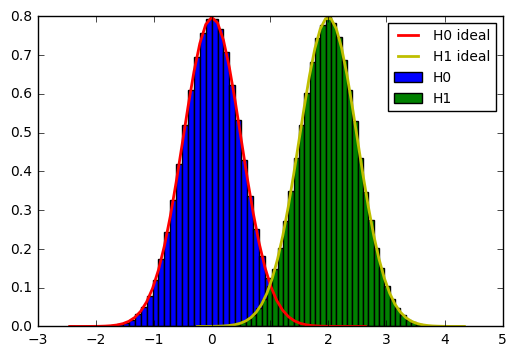

In [50]:
_, bins_0, _ = plt.hist(H0, 50, normed=True, label='H0')
_, bins_1, _ = plt.hist(H1, 50, normed=True, label='H1')
plt.plot(bins_0, 1/(sigma_H0 * np.sqrt(2 * np.pi)) * np.exp( - (bins_0 - mu_H0)**2 / (2 * sigma_H0**2) ), 
         linewidth=2, color='r', label='H0 ideal')
plt.plot(bins_1, 1/(sigma_H1 * np.sqrt(2 * np.pi)) * np.exp( - (bins_1 - mu_H1)**2 / (2 * sigma_H1**2) ), 
         linewidth=2, color='y', label='H1 ideal')
plt.legend(fontsize=10)
plt.show()

Merge and shuffle them, use VAE to train on data

In [51]:
data = np.concatenate((H0, H1), axis=0)
np.random.shuffle(data)

In [52]:
def vae_train(sess, optimizer, cost, x, n_samples, batch_size=100, learn_rate=0.001, train_epoch=10, verb=1, verb_step=5):
    
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_x = data[i*batch_size:(i+1)*batch_size]
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
        
        if verb:
            if epoch % verb_step == 0:
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))

In [53]:
config = {}
config['x_in'] = 1
config['encoder_1'] = 1
config['encoder_2'] = 1
config['decoder_1'] = 1
config['decoder_2'] = 1
config['z'] = 2
batch_size = 50000
(sess, optimizer, cost, x, x_prime) = vae_init(batch_size=batch_size, config=config)

In [54]:
vae_train(sess, optimizer, cost, x, n_samples*2, batch_size=batch_size, learn_rate=0.00001, train_epoch=26)

Epoch:0001 cost= 15.858934402
Epoch:0006 cost= 5.404365313
Epoch:0011 cost= 3.102086318
Epoch:0016 cost= 2.010665572
Epoch:0021 cost= 1.409558722
Epoch:0026 cost= 1.052325895


### Reconstruct Data

In [55]:
total_batch = int(n_samples*2 / batch_size)
data_reconstruct = []
for i in range(total_batch):
    data_reconstruct.append(sess.run(x_prime,  feed_dict={x: data[i*batch_size:(i+1)*batch_size]}))
data_reconstruct = np.concatenate(data_reconstruct, axis=0)

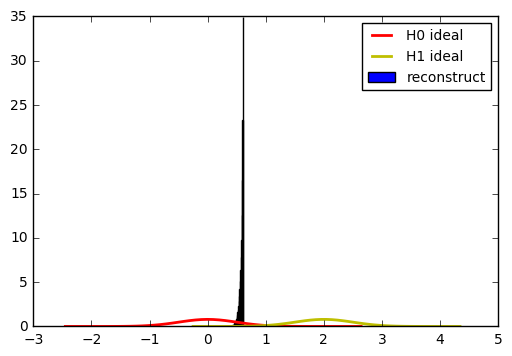

In [59]:
_, bins, _ = plt.hist(data_reconstruct, bins=50, normed=True, label='reconstruct')
plt.plot(bins_0, 1/(sigma_H0 * np.sqrt(2 * np.pi)) * np.exp( - (bins_0 - mu_H0)**2 / (2 * sigma_H0**2) ), 
         linewidth=2, color='r', label='H0 ideal')
plt.plot(bins_1, 1/(sigma_H1 * np.sqrt(2 * np.pi)) * np.exp( - (bins_1 - mu_H1)**2 / (2 * sigma_H1**2) ), 
         linewidth=2, color='y', label='H1 ideal')
plt.legend(fontsize=10)
plt.show()

### 2D Gaussian

Generate synthetic data with two classes:  
$H0 \sim \mathcal{N}((0,0), (0.3,0.3))$  
$H1 \sim \mathcal{N}((2,2), (0.1,0.9))$  
Each of them have 10000 samples

In [60]:
mu_H0, sigma_H0 = (0,0), [[0.3,0],[0,0.3]]
mu_H1, sigma_H1 = (2,2), [[0.1,0],[0,0.9]]
n_samples = 500000
H0 = np.random.multivariate_normal(mu_H0, sigma_H0, n_samples).reshape((-1,2))
H1 = np.random.multivariate_normal(mu_H1, sigma_H1, n_samples).reshape((-1,2))
H0_label = np.zeros((n_samples, 1))
H0_label = np.ones((n_samples, 1))

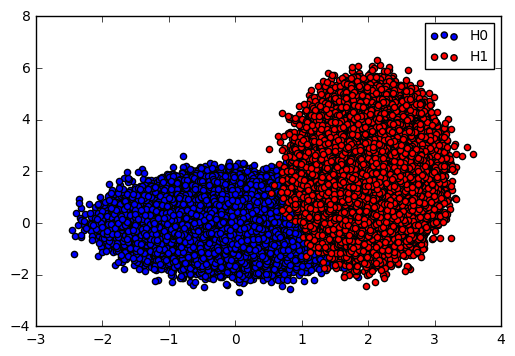

In [61]:
plt.scatter(H0[:,0], H0[:,1], c='b', label='H0')
plt.scatter(H1[:,0], H1[:,1], c='r', label='H1')
plt.legend(fontsize=10)
plt.show()

In [62]:
data = np.concatenate((H0, H1), axis=0)
np.random.shuffle(data)

In [63]:
def vae_train(sess, optimizer, cost, x, n_samples, batch_size=100, learn_rate=0.001, train_epoch=10, verb=1, verb_step=5):
    
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_x = data[i*batch_size:(i+1)*batch_size,:]
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
        
        if verb:
            if epoch % verb_step == 0:
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))

In [80]:
config = {}
config['x_in'] = 2
config['encoder_1'] = 1
config['encoder_2'] = 1
config['decoder_1'] = 1
config['decoder_2'] = 1
config['z'] = 2
batch_size = 10000
(sess, optimizer, cost, x, x_prime) = vae_init(batch_size=batch_size, config=config)

In [81]:
vae_train(sess, optimizer, cost, x, n_samples*2, batch_size=batch_size, learn_rate=0.001, train_epoch=26)

Epoch:0001 cost= 1.852449260
Epoch:0006 cost= 0.616509704
Epoch:0011 cost= 0.269367470
Epoch:0016 cost= 0.174044882
Epoch:0021 cost= 0.140571341
Epoch:0026 cost= 0.076080143


### Reconstruct Data

In [82]:
total_batch = int(n_samples*2 / batch_size)
data_reconstruct = []
for i in range(total_batch):
    data_reconstruct.append(sess.run(x_prime,  feed_dict={x: data[i*batch_size:(i+1)*batch_size,:]}))
data_reconstruct = np.concatenate(data_reconstruct, axis=0)

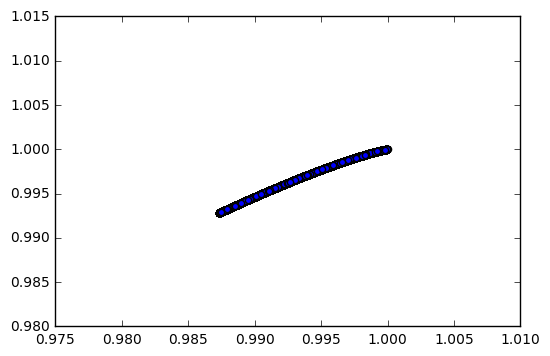

In [83]:
plt.scatter(data_reconstruct[:,0], data_reconstruct[:,1])
plt.show()

### Conclusion

Since Variational autoencoder is designed to find low dimensional manifold for higher dimensional data, it does not perform very well on low dimensional "easy" (Gaussian) data. From the two examples shown above, the VAE cannot reproduce similar dataset.  
However, for a more complex data (e.g. MNIST dataset, which we will shown in another ipynb) with higher dimension and more texture, the VAE can actually perform well on it.